## Imports and Performance Settings

In [22]:
import json
import random
import time
from pathlib import Path
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as mask_utils

from tqdm import tqdm

torch.backends.cudnn.benchmark = True
if hasattr(torch, "set_float32_matmul_precision"):
    torch.set_float32_matmul_precision("high")  # Improves matmul performance on newer PyTorch versions; safe to skip if unsupported.

## Paths, Training Hyperparameters, and Evaluation/Visualization Settings

In [3]:
SPLIT_DIR = Path("artifacts/torchvision_maskrcnn/splits")
TRAIN_JSON = SPLIT_DIR / "train.json"
VAL_JSON   = SPLIT_DIR / "val.json"
TEST_JSON  = SPLIT_DIR / "test.json"

DATA_ROOT = Path("data")

OUT_DIR  = Path("artifacts/torchvision_maskrcnn")
CKPT_DIR = OUT_DIR / "checkpoints"
for d in (OUT_DIR, CKPT_DIR):
    d.mkdir(parents=True, exist_ok=True)

METRICS_PATH = OUT_DIR / "metrics.json"

# --- Data augmentation ---
AUG_COLOR_JITTER = True
JITTER_BRIGHTNESS = 0.20
JITTER_CONTRAST   = 0.20
JITTER_SATURATION = 0.15
JITTER_HUE        = 0.02

SEED = 42
EPOCHS = 5
BATCH_SIZE = 2
ACCUM_STEPS = 2
NUM_WORKERS = 0 # DataLoader workers;

# --- Optimizer + LR scheduler ---
LR = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0005
STEP_SIZE = 3
GAMMA = 0.1

# --- Evaluation / visualization thresholds ---
USE_MASKS = True
SCORE_THR_VIS = 0.40
MASK_THR_VIS  = 0.50
EVAL_EVERY = 1

## Environment Setup

In [4]:
def seed_everything(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
USE_AMP = (device.type == "cuda")

USE_TF32 = (device.type == "cuda")
if USE_TF32:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

print("device:", device)
print("USE_AMP:", USE_AMP)
print("USE_TF32:", USE_TF32)

device: cuda
USE_AMP: True
USE_TF32: True


## Data Access: Image Path Resolver (Fast Lookup for COCO file_name)

In [5]:
class ImagePathResolver:
    def __init__(self, root_dir: Path, exts=(".jpg",)):
        self.root_dir = Path(root_dir)
        self.exts = tuple(e.lower() for e in exts)
        self.by_rel = {}
        self.by_name = {}
        self.cache = {}

        n = 0
        for p in self.root_dir.rglob("*"):
            if p.is_file() and p.suffix.lower() in self.exts:
                rel = str(p.relative_to(self.root_dir)).replace("\\", "/")
                self.by_rel[rel] = p
                self.by_name.setdefault(p.name, p)
                n += 1
        print(f"[resolver] Indexed {n} images.")

    def resolve(self, file_name: str) -> Path:
        if file_name in self.cache:
            return self.cache[file_name]

        key = file_name.replace("\\", "/")
        p = self.by_rel.get(key)
        if p is None:
            p = self.by_name.get(Path(key).name)

        if p is None:
            raise FileNotFoundError(f"Image not found: {file_name}")

        self.cache[file_name] = p
        return p

resolver = ImagePathResolver(DATA_ROOT)

[resolver] Indexed 8612 images.


## Label Mapping: COCO Category IDs to Model Class Indices

In [6]:
train_coco = COCO(str(TRAIN_JSON))

cat_ids = sorted(train_coco.getCatIds())
catid2label = {cid: i + 1 for i, cid in enumerate(cat_ids)}  # background=0
label2catid = {v: k for k, v in catid2label.items()}

NUM_CLASSES = len(catid2label) + 1
print("Classes (incl. background):", NUM_CLASSES)

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
Classes (incl. background): 11


## Preprocessing and Augmentation: Detection/Segmentation Transforms and Collate Function

In [7]:
class ComposeDet:
    def __init__(self, transforms):
        self.transforms = transforms
        
    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class ToTensorDet:
    def __call__(self, image, target):
        return F.to_tensor(image), target

class RandomHorizontalFlipDet:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, image, target):
        if random.random() < self.p:
            image = F.hflip(image)
            _, h, w = image.size()
            if "boxes" in target:
                boxes = target["boxes"]
                boxes = boxes.clone()
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
                target["boxes"] = boxes
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
        return image, target

class ColorJitterDet:
    def __init__(self, brightness, contrast, saturation, hue):
        self.jitter = torchvision.transforms.ColorJitter(brightness=brightness, contrast=contrast, saturation=saturation, hue=hue)
    def __call__(self, image, target):
        return self.jitter(image), target

def get_transforms(train: bool):
    ts = [ToTensorDet()]
    if train:
        ts.append(RandomHorizontalFlipDet(0.5))
        if AUG_COLOR_JITTER:
            ts.append(ColorJitterDet(JITTER_BRIGHTNESS, JITTER_CONTRAST, JITTER_SATURATION, JITTER_HUE))
    return ComposeDet(ts)

def collate_fn(batch):
    return tuple(zip(*batch))

## Dataset Definition: COCO Parsing, Target Construction, and Mask Decoding

In [8]:
def coco_ann_to_mask(segmentation, height: int, width: int) -> torch.Tensor:
    if segmentation is None:
        return torch.zeros((height, width), dtype=torch.uint8)

    if isinstance(segmentation, list):
        rles = mask_utils.frPyObjects(segmentation, height, width)
        rle = mask_utils.merge(rles)
    elif isinstance(segmentation, dict) and "counts" in segmentation:
        rle = segmentation
    else:
        return torch.zeros((height, width), dtype=torch.uint8)

    m = mask_utils.decode(rle)
    if m.ndim == 3:
        m = np.any(m, axis=2).astype(np.uint8)
    return torch.from_numpy(m.astype(np.uint8))

class CocoDetDataset(Dataset):
    def __init__(self, json_path: Path, resolver: ImagePathResolver, catid2label: dict,
                 transforms=None, use_masks: bool = True):
        self.json_path = Path(json_path)
        self.coco = COCO(str(self.json_path))
        self.ids = sorted(self.coco.getImgIds())
        self.resolver = resolver
        self.catid2label = catid2label
        self.transforms = transforms
        self.use_masks = use_masks

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx: int):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = self.resolver.resolve(img_info["file_name"])

        image = Image.open(img_path).convert("RGB")
        w, h = image.size

        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        masks = []
        area = []
        iscrowd = []

        for a in anns:
            x, y, bw, bh = a.get("bbox", [0,0,0,0])
            if bw <= 1 or bh <= 1:
                continue
            x1, y1, x2, y2 = x, y, x + bw, y + bh
            boxes.append([x1, y1, x2, y2])

            cid = a["category_id"]
            if cid not in self.catid2label:
                continue
            labels.append(self.catid2label[cid])

            area.append(float(a.get("area", bw * bh)))
            iscrowd.append(int(a.get("iscrowd", 0)))

            if self.use_masks:
                m = coco_ann_to_mask(a.get("segmentation", None), h, w)
                masks.append(m)

        if len(boxes) == 0:
            boxes_t = torch.zeros((0, 4), dtype=torch.float32)
            labels_t = torch.zeros((0,), dtype=torch.int64)
            area_t = torch.zeros((0,), dtype=torch.float32)
            iscrowd_t = torch.zeros((0,), dtype=torch.int64)
            if self.use_masks:
                masks_t = torch.zeros((0, h, w), dtype=torch.uint8)
        else:
            boxes_t = torch.tensor(boxes, dtype=torch.float32)
            labels_t = torch.tensor(labels, dtype=torch.int64)
            area_t = torch.tensor(area, dtype=torch.float32)
            iscrowd_t = torch.tensor(iscrowd, dtype=torch.int64)
            if self.use_masks:
                masks_t = torch.stack(masks, dim=0).to(torch.uint8)

        target = {
            "boxes": boxes_t,
            "labels": labels_t,
            "image_id": torch.tensor([img_id], dtype=torch.int64),
            "area": area_t,
            "iscrowd": iscrowd_t
        }
        if self.use_masks:
            target["masks"] = masks_t

        if self.transforms is not None:
            image, target = self.transforms(image, target)

        return image, target

## Data Pipeline: Dataset Instances and DataLoaders (Train/Val/Test)

In [9]:
train_ds = CocoDetDataset(TRAIN_JSON, resolver, catid2label, transforms=get_transforms(True),  use_masks=USE_MASKS)
val_ds   = CocoDetDataset(VAL_JSON,   resolver, catid2label, transforms=get_transforms(False), use_masks=USE_MASKS)
test_ds  = CocoDetDataset(TEST_JSON,  resolver, catid2label, transforms=get_transforms(False), use_masks=USE_MASKS)

print("train images:", len(train_ds), "| val images:", len(val_ds), "| test images:", len(test_ds))

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=(device.type == "cuda"),
)

val_loader = DataLoader(
    val_ds,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=(device.type == "cuda"),
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=NUM_WORKERS,
    collate_fn=collate_fn,
    pin_memory=(device.type == "cuda"),
)

_images, _targets = next(iter(train_loader))
print("Example tensor shape:", _images[0].shape)

loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
train images: 5126 | val images: 1578 | test images: 1676
Example tensor shape: torch.Size([3, 1080, 1920])


## Model Setup

In [10]:
def build_model(num_classes: int):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)
    return model

model = build_model(NUM_CLASSES).to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

scaler = torch.amp.GradScaler("cuda", enabled=USE_AMP)

def autocast_ctx():
    return torch.amp.autocast("cuda", enabled=USE_AMP)

best_path = CKPT_DIR / "best.pth"
last_path = CKPT_DIR / "last.pth"

def save_ckpt(path: Path, epoch: int, best_score: float):
    torch.save({
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": epoch,
        "best_score": best_score,
        "cfg": {
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "ACCUM_STEPS": ACCUM_STEPS,
            "LR": LR,
            "USE_MASKS": USE_MASKS
        }
    }, path)

print("Model ready.")

Model ready.


## Evaluation: COCO-Style Metrics (BBox + Segmentation) with COCOeval

In [11]:
def train_one_epoch(epoch: int) -> float:
    model.train()
    pbar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Train {epoch}", leave=False)

    running = 0.0
    n = 0
    t0 = time.time()

    optimizer.zero_grad(set_to_none=True)

    for step, (images, targets) in pbar:
        images = [img.to(device, non_blocking=True) for img in images]
        targets = [{k: v.to(device, non_blocking=True) for k, v in t.items()} for t in targets]

        with autocast_ctx():
            loss_dict = model(images, targets)
            loss = sum(loss_dict.values())
            loss = loss / ACCUM_STEPS

        scaler.scale(loss).backward()

        if step % ACCUM_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        loss_val = float(loss.item()) * ACCUM_STEPS
        running += loss_val
        n += 1

        it_s = (time.time() - t0) / step
        pbar.set_postfix(loss=running / n, lr=optimizer.param_groups[0]["lr"], s_it=f"{it_s:.2f}")

    if len(train_loader) % ACCUM_STEPS != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

    return running / max(1, n)

## Model Evaluation: COCO Metrics for Bounding Boxes and Instance Segmentation

In [12]:
def _encode_mask(mask_bool: np.ndarray):
    rle = mask_utils.encode(np.asfortranarray(mask_bool.astype(np.uint8)))
    rle["counts"] = rle["counts"].decode("utf-8")
    return rle

@torch.no_grad()
def coco_eval(model, ds: CocoDetDataset, loader: DataLoader, iou_types=("bbox", "segm")):
    model.eval()
    coco_gt = ds.coco

    results_bbox = []
    results_segm = []

    pbar = tqdm(loader, desc="Val", leave=False)
    for images, targets in pbar:
        images = [img.to(device, non_blocking=True) for img in images]
        outputs = model(images)

        for out, tgt in zip(outputs, targets):
            img_id = int(tgt["image_id"].item())

            boxes = out["boxes"].detach().cpu().numpy()
            scores = out["scores"].detach().cpu().numpy()
            labels = out["labels"].detach().cpu().numpy()

            masks = None
            if "masks" in out:
                masks = out["masks"].detach().cpu().numpy()  # [N,1,H,W]

            for i in range(len(scores)):
                score = float(scores[i])
                if score <= 0:
                    continue

                label = int(labels[i])
                cat_id = int(label2catid.get(label, -1))
                if cat_id < 0:
                    continue

                x1, y1, x2, y2 = boxes[i]
                w = float(x2 - x1)
                h = float(y2 - y1)
                if w <= 0 or h <= 0:
                    continue

                if "bbox" in iou_types:
                    results_bbox.append({
                        "image_id": img_id,
                        "category_id": cat_id,
                        "bbox": [float(x1), float(y1), w, h],
                        "score": score
                    })

                if ("segm" in iou_types) and (masks is not None):
                    m = masks[i, 0]
                    rle = _encode_mask(m > 0.5)
                    results_segm.append({
                        "image_id": img_id,
                        "category_id": cat_id,
                        "segmentation": rle,
                        "score": score
                    })

    stats = {}

    pred_bbox = None
    if "bbox" in iou_types:
        coco_dt = coco_gt.loadRes(results_bbox) if len(results_bbox) else coco_gt.loadRes([])
        ev = COCOeval(coco_gt, coco_dt, iouType="bbox")
        ev.evaluate()
        ev.accumulate()
        ev.summarize()
        stats["bbox"] = {
            "AP": float(ev.stats[0]),
            "AP50": float(ev.stats[1]),
            "AP75": float(ev.stats[2]),
        }
        pred_bbox = results_bbox

    pred_segm = None
    if "segm" in iou_types:
        coco_dt = coco_gt.loadRes(results_segm) if len(results_segm) else coco_gt.loadRes([])
        ev = COCOeval(coco_gt, coco_dt, iouType="segm")
        ev.evaluate()
        ev.accumulate()
        ev.summarize()
        stats["segm"] = {
            "AP": float(ev.stats[0]),
            "AP50": float(ev.stats[1]),
            "AP75": float(ev.stats[2]),
        }
        pred_segm = results_segm

    return stats, pred_bbox, pred_segm

## Training Loop

In [13]:
history = []
best_score = -1.0
best_metric = "segm_AP" if USE_MASKS else "bbox_AP"

def _save_metrics():
    METRICS_PATH.write_text(json.dumps(history, indent=2), encoding="utf-8")

for epoch in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(epoch)
    lr_scheduler.step()

    row = {
        "epoch": epoch,
        "train_loss": float(tr_loss),
        "lr": float(optimizer.param_groups[0]["lr"]),
    }
    print(f"Epoch {epoch}/{EPOCHS} | loss={tr_loss:.4f}")

    do_eval = (epoch % EVAL_EVERY == 0) or (epoch == 1) or (epoch == EPOCHS)
    if do_eval:
        stats, pred_bbox, pred_segm = coco_eval(
            model, val_ds, val_loader,
            iou_types=("bbox", "segm") if USE_MASKS else ("bbox",)
        )

        bbox_ap = stats["bbox"]["AP"]
        segm_ap = stats["segm"]["AP"] if USE_MASKS else None

        row["val_bbox_AP"] = float(bbox_ap)
        if USE_MASKS:
            row["val_segm_AP"] = float(segm_ap)
            print(f"  VAL bbox_AP={bbox_ap:.4f} | segm_AP={segm_ap:.4f}")
            score = float(segm_ap) 
        else:
            print(f"  VAL bbox_AP={bbox_ap:.4f}")
            score = float(bbox_ap)

        save_ckpt(last_path, epoch, best_score)

        if score > best_score:
            best_score = score
            save_ckpt(best_path, epoch, best_score)
            print(f"  Saved BEST: {best_metric}={best_score:.4f} -> {best_path}")
            
    history.append(row)
    _save_metrics()

print(f"Done. Best {best_metric}: {best_score:.4f}")

Epoch 1/5 | loss=0.7250


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=3.05s).
Accumulating evaluation results...
DONE (t=1.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.262
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.415
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.116
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.281
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 2/5 | loss=0.5732


Loading and preparing results...
DONE (t=0.33s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.79s).
Accumulating evaluation results...
DONE (t=0.92s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.417
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.547
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 3/5 | loss=0.5341


Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.88s).
Accumulating evaluation results...
DONE (t=0.81s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.404
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.593
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.462
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.261
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.437
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.408
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.576
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.587
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 4/5 | loss=0.4450


Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.84s).
Accumulating evaluation results...
DONE (t=0.70s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.458
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.639
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.306
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.617
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.628
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

Epoch 5/5 | loss=0.4201


Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.41s).
Accumulating evaluation results...
DONE (t=0.64s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.474
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.660
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.243
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.313
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.513
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.451
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.621
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

# test

In [14]:
print(f"\nLoading BEST checkpoint ({best_metric}):", best_path)
ckpt = torch.load(best_path, map_location=device)
model.load_state_dict(ckpt["model"])
model.to(device).eval()

test_stats, pred_bbox, pred_segm = coco_eval(model, test_ds, test_loader, iou_types=("bbox", "segm") if USE_MASKS else ("bbox",))

print("\nTEST results:")
print("  bbox_AP:", test_stats["bbox"]["AP"], "| AP50:", test_stats["bbox"]["AP50"], "| AP75:", test_stats["bbox"]["AP75"])
if USE_MASKS:
    print("  segm_AP:", test_stats["segm"]["AP"], "| AP50:", test_stats["segm"]["AP50"], "| AP75:", test_stats["segm"]["AP75"])


Loading BEST checkpoint (segm_AP): artifacts\torchvision_maskrcnn\checkpoints\best.pth


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.90s).
Accumulating evaluation results...
DONE (t=0.68s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.480
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.276
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.510
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.652
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

## Vizualization

In [20]:
def show_side_by_side(img1, title1, img2, title2):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    axs[0].imshow(img1.permute(1, 2, 0))
    axs[0].set_title(title1)
    axs[0].axis("off")
    axs[1].imshow(img2.permute(1, 2, 0))
    axs[1].set_title(title2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

def draw_pred(image_uint8, pred, score_thr=0.4, mask_thr=0.5, mask_alpha=0.7, draw_boxes=False):
    boxes = pred["boxes"].detach().cpu()
    scores = pred["scores"].detach().cpu()
    keep = scores >= score_thr
    boxes = boxes[keep]

    out = image_uint8.clone()

    if USE_MASKS and ("masks" in pred) and keep.any():
        pm = pred["masks"].detach().cpu()[keep, 0] > mask_thr
        if pm.numel() > 0:
            out = torchvision.utils.draw_segmentation_masks(out, pm, alpha=mask_alpha)

    if draw_boxes and boxes.numel() > 0:
        out = torchvision.utils.draw_bounding_boxes(out, boxes, width=2)

    return out

def draw_gt(image_uint8, target, mask_alpha=0.7, draw_boxes=False):
    out = image_uint8.clone()
    if USE_MASKS and ("masks" in target) and target["masks"].numel() > 0:
        out = torchvision.utils.draw_segmentation_masks(out, target["masks"].cpu().bool(), alpha=mask_alpha)
    if draw_boxes and ("boxes" in target) and target["boxes"].numel() > 0:
        out = torchvision.utils.draw_bounding_boxes(out, target["boxes"].cpu(), width=2)
    return out

@torch.no_grad()
def visualize_random(ds, n=6, score_thr=0.4, mask_thr=0.5, draw_boxes=False):
    model.eval()
    idxs = random.sample(range(len(ds)), k=min(n, len(ds)))
    for idx in idxs:
        img, target = ds[idx]
        pred = model([img.to(device, non_blocking=True)])[0]

        img_uint8 = (img.clamp(0, 1) * 255).to(torch.uint8).cpu()
        gt_drawn = draw_gt(img_uint8, target, mask_alpha=0.70, draw_boxes=draw_boxes)
        pr_drawn = draw_pred(img_uint8, pred, score_thr=score_thr, mask_thr=mask_thr, mask_alpha=0.70, draw_boxes=draw_boxes)
        show_side_by_side(gt_drawn, f"GT idx={idx}", pr_drawn, f"Pred thr={score_thr} mask_thr={mask_thr}")

Loaded epoch: 5 | best_score: 0.3926386636092277


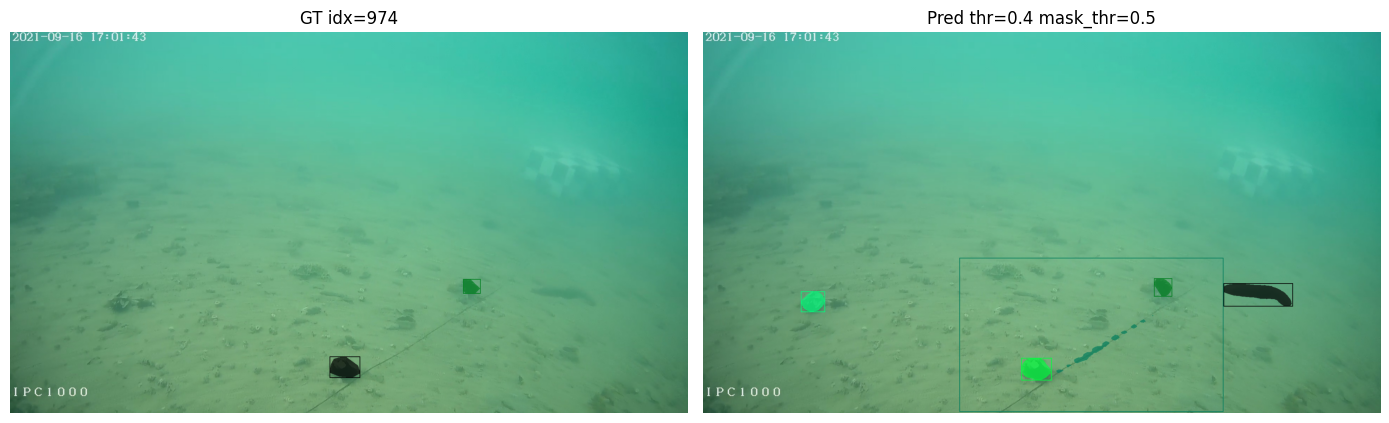

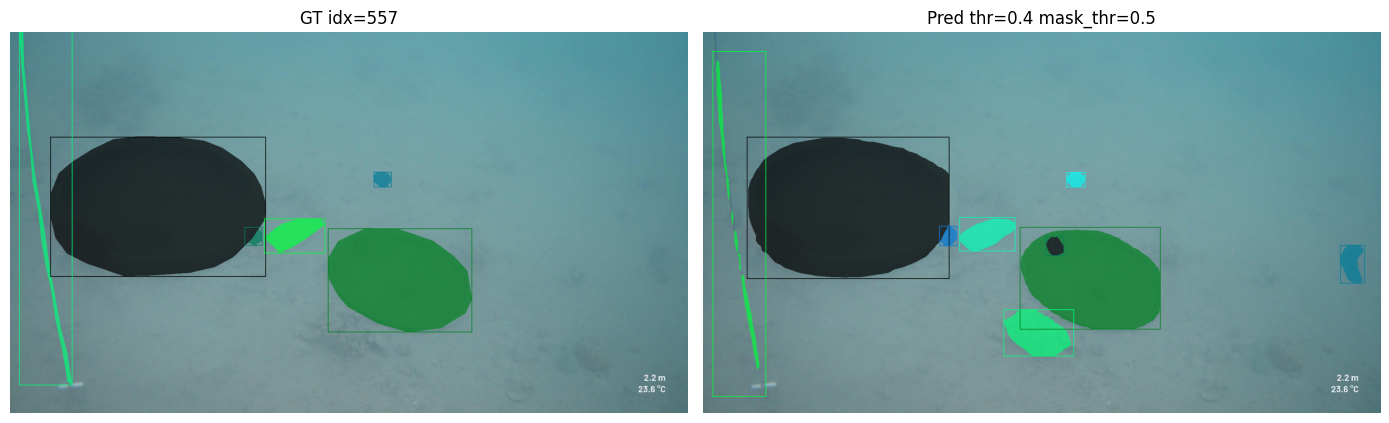

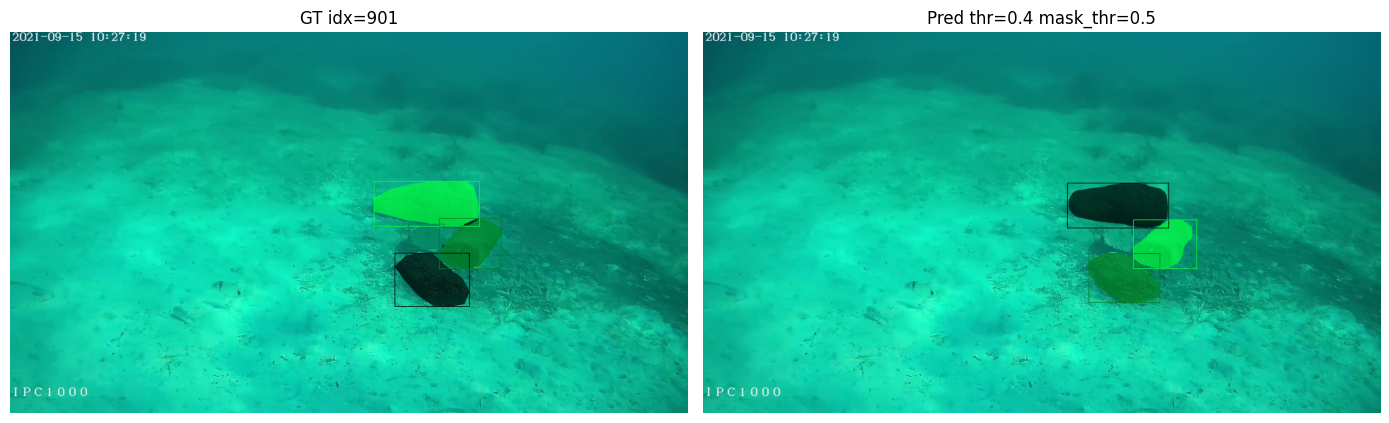

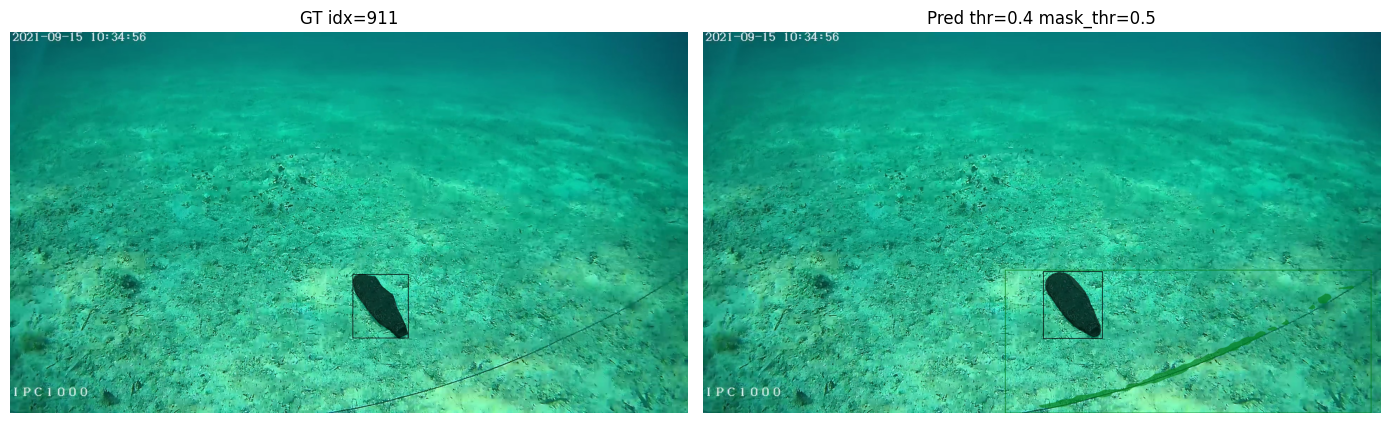

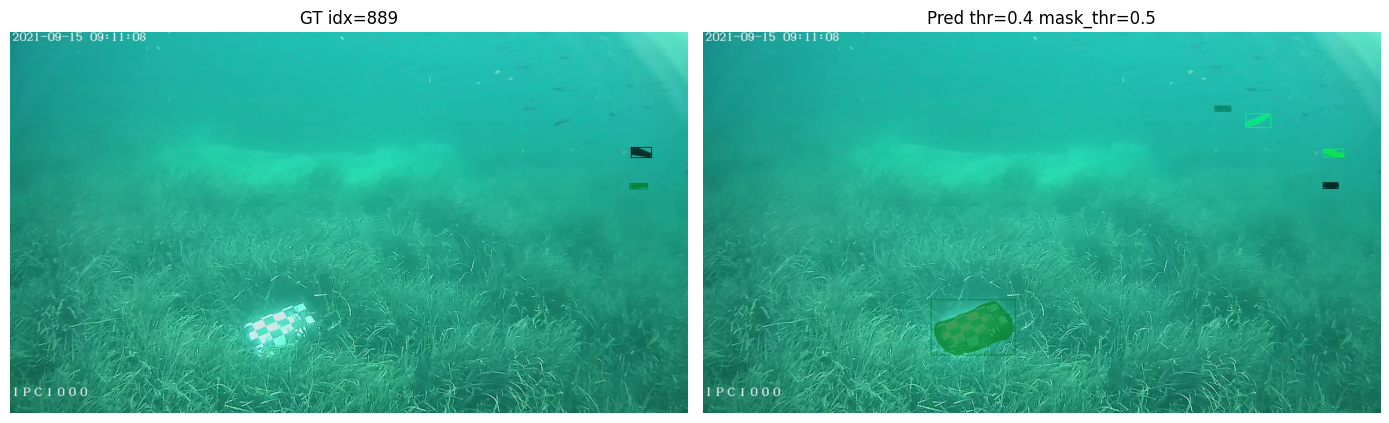

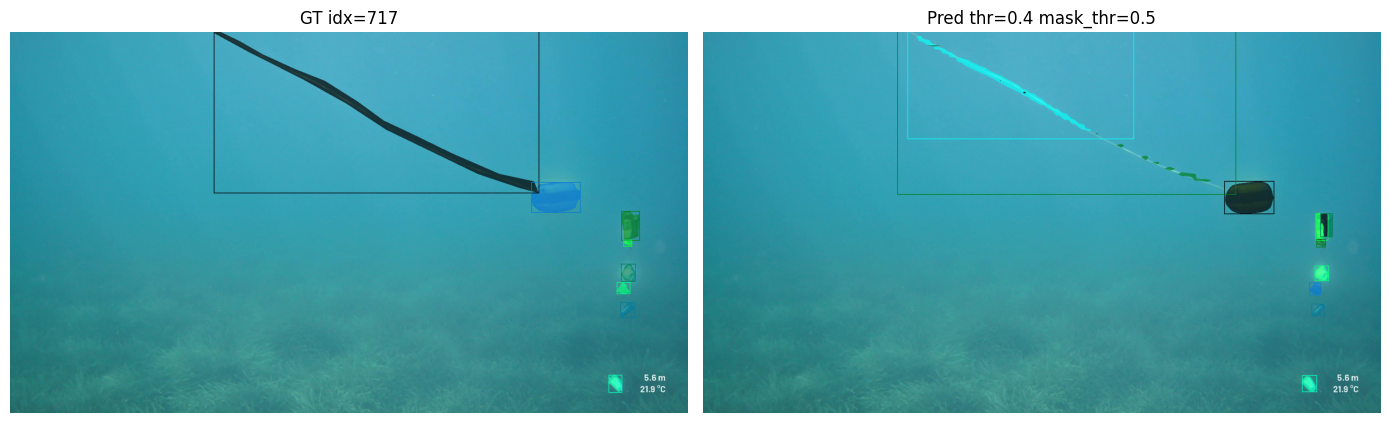

In [27]:
best_path = r"artifacts\torchvision_maskrcnn\checkpoints\best.pth"
ckpt = torch.load(best_path, map_location=device)

model.load_state_dict(ckpt["model"])
model.to(device).eval()

print("Loaded epoch:", ckpt["epoch"], "| best_score:", ckpt["best_score"])

visualize_random(test_ds, n=6, score_thr=SCORE_THR_VIS, mask_thr=MASK_THR_VIS, draw_boxes=True)